In [1]:
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# EDA

In [2]:
np.random.seed(42)

In [3]:
DATA_DIR = join('..', 'data', 'raw')

In [4]:
train_full_df = pd.read_csv(join(DATA_DIR, 'train.tsv'), sep='\t')
train_full_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0
1,402555,536040,536041,How do I control my horny emotions?,How do you control your horniness?,1
2,360472,364011,490273,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0
3,150662,155721,7256,What can one do after MBBS?,What do i do after my MBBS ?,1
4,183004,279958,279959,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0


In [5]:
train_full_df.shape

(363846, 6)

In [6]:
test_df = pd.read_csv(join(DATA_DIR, 'dev.tsv'), sep='\t')
test_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,0
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,1
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,0


In [7]:
test_df.shape

(40430, 6)

In [8]:
train_df, dev_df = train_test_split(train_full_df, test_size=0.1, random_state=42)

In [9]:
len(train_df), len(dev_df)

(327461, 36385)

In [10]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,1
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,0
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,1


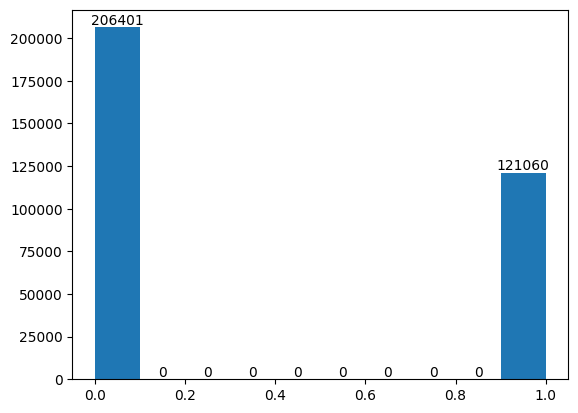

In [11]:
_, _, bars = plt.hist(train_df.is_duplicate)
plt.bar_label(bars)
plt.show()

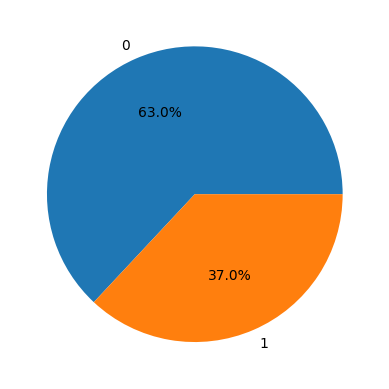

In [12]:
plt.pie(
    train_df.is_duplicate.value_counts(), 
    labels=train_df.is_duplicate.value_counts().index, 
    autopct='%1.1f%%'
)
plt.show()

In [13]:
non_asciis, non_strs = [], []

for i, row in train_df.iterrows():
    for question in [row['question1'], row['question2']]:
        if type(question) != str:
            non_strs.append(row)
        elif not question.isascii():
            non_asciis.append(row)

len(non_strs), len(non_asciis)

(0, 7738)

In [14]:
non_strs

[]

In [15]:
non_asciis[0]

id                                                       69282
qid1                                                    119565
qid2                                                    119566
question1       Is the new TV show “Westworld” worth watching?
question2                         Is westworld worth watching?
is_duplicate                                                 1
Name: 14771, dtype: object

# Data preparation

In [16]:
train_df = train_df.fillna("") # replace NaN with empty string
dev_df = dev_df.fillna("")
test_df = test_df.fillna("")

In [17]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/binh_pdc01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
word_tokenize('How can I create an Android app?'.lower())

['how', 'can', 'i', 'create', 'an', 'android', 'app', '?']

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from nltk.tokenize import word_tokenize

torch.manual_seed(42)
device = 'cpu' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
def get_X_y(df):
    X = df[['question1', 'question2']]
    X['tokenized_q1'] = X['question1'].apply(lambda x: word_tokenize(str(x).lower()))
    X['tokenized_q2'] = X['question2'].apply(lambda x: word_tokenize(str(x).lower()))
    X = X[['tokenized_q1', 'tokenized_q2']].reset_index(drop=True)

    y = df['is_duplicate']
    y = torch.tensor(y.values, dtype=torch.float32)

    return X, y

In [21]:
X_train, y_train = get_X_y(train_df)
X_val, y_val = get_X_y(dev_df)
X_test, y_test = get_X_y(test_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
X_train.head()

,tokenized_q1,tokenized_q2
0,"[which, topic, is, the, most, followed, in, qu...","[what, topic, on, quora, has, the, most, follo..."
1,"[what, does, it, feel, like, to, have, sex, wi...","[is, it, possible, to, eat, more, than, you, w..."
2,"[can, i, get, back, my, best, friend, ?]","[how, do, i, get, back, to, my, best, friend, ..."
3,"[are, there, solar, systems, that, act, like, ...","[as, a, navy, seal, do, you, feel, as, if, peo..."
4,"[why, are, there, only, few, magnets, ?]","[why, is, there, only, few, magnets, ?]"


In [23]:
X_train.shape

(327461, 2)

In [24]:
y_train, y_train.shape

(tensor([1., 0., 0.,  ..., 0., 0., 1.]), torch.Size([327461]))

In [25]:
word_count = {}

for col in ['tokenized_q1', 'tokenized_q2']:
    for lst in X_train[col]:
        for word in lst:
            word_count[word] = word_count.get(word, 0) + 1

In [26]:
len(word_count)

101407

In [27]:
sorted_word_counts = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

In [28]:
sorted_word_counts[:10]

[('?', 690525),
 ('the', 305720),
 ('what', 262909),
 ('is', 219292),
 ('i', 179948),
 ('how', 178512),
 ('a', 170938),
 ('to', 166555),
 ('in', 159168),
 ('do', 136678)]

In [29]:
for i, (_, count) in enumerate(sorted_word_counts):
    if count == 1:
        print(f"Number of words occurring more than once: {i}")
        break

Number of words occurring more than once: 53812


In [30]:
vocab = set(word_count.keys())
vocab.add('<>SEP</>') # separator between 2 sentences
vocab.add('<>UKN</>')

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

# RNN models

In [31]:
class RNNModel(nn.Module):
    
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, num_rnn_layers=1,
        num_linear_layers=1, dropout=0, rnn_type='rnn'
    ):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True, dropout=dropout)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True, dropout=dropout)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_rnn_layers, batch_first=True, dropout=dropout)
        
        self.fcs = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_linear_layers-1)] 
            + [nn.Linear(hidden_dim, 1)]
        )
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x.mean(dim=1) 
        for fc in self.fcs[:-1]:
            x = F.relu(fc(x))
        x = self.fcs[-1](x)
        return self.sigmoid(x)
        

class DuplicateQuestionDataset(Dataset):
    
    def __init__(self, questions, labels, word_to_idx):
        self.questions = questions
        self.labels = labels
        self.word_to_idx = word_to_idx

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q1, q2 = self.questions.iloc[idx]
        word_indices = [self.word_to_idx.get(word, self.word_to_idx['<>UKN</>']) for word in q1]
        word_indices.append(self.word_to_idx['<>SEP</>'])
        word_indices.extend([self.word_to_idx.get(word, self.word_to_idx['<>UKN</>']) for word in q1])
        return torch.tensor(word_indices).to(device), self.labels[idx].to(device)

In [32]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_pad(batch):
    questions, labels = zip(*batch)
    padded_questions = pad_sequence(questions, batch_first=True, padding_value=0)
    return padded_questions, torch.stack(labels)

batch_size = 512

train_dataset = DuplicateQuestionDataset(X_train, y_train, word_to_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_pad)

val_dataset = DuplicateQuestionDataset(X_val, y_val, word_to_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_pad)

test_dataset = DuplicateQuestionDataset(X_val, y_val, word_to_idx)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_pad)

In [33]:
def train(model, criterion, optimizer, num_epochs=10, early_stopping_patience=None):
    
    def validate(model):
        model.eval()
        total_loss, sample_count = 0, 0
        with torch.no_grad():
            for (questions, labels) in val_loader:
                outputs = model(questions)
                loss = criterion(outputs.view(-1), labels)
                total_loss += loss.item()
                sample_count += labels.size(0)
        average_loss = total_loss / sample_count
        return average_loss
    
    best_loss = np.inf
    consecutive_no_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()  
        total_loss, sample_counts = 0, 0
        for (questions, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(questions)
            loss = criterion(outputs.view(-1), labels)
            total_loss += loss.item()
            sample_counts += labels.size(0)
            loss.backward()
            optimizer.step()
            
        val_loss = validate(model)
        print(f"Epoch {epoch+1}: train loss = {(total_loss / sample_counts):.4f}; val loss = {val_loss:.4f}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            
        if early_stopping_patience and consecutive_no_improvement >= early_stopping_patience:
            print(f"Early stopping after {epoch + 1} epochs with no improvement.")
            break
            
    return model


def evaluate(model, print_report=False):
    model.eval()

    def get_predictions_and_labels(loader):
        predictions = []
        true_labels = []
        for questions, labels in loader:
            outputs = model(questions)
            predicted = (outputs > 0.5).float().view(-1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        return predictions, true_labels

    if print_report:
        train_predictions, train_labels = get_predictions_and_labels(train_loader)
        print("Train Classification Report:")
        print(classification_report(train_labels, train_predictions, zero_division=1))

        val_predictions, val_labels = get_predictions_and_labels(val_loader)
        print("Validation Classification Report:")
        print(classification_report(val_labels, val_predictions, zero_division=1))
    else: 
        val_predictions, val_labels = get_predictions_and_labels(val_loader)
    return accuracy_score(val_labels, val_predictions)

In [34]:
model = RNNModel(
    vocab_size, embedding_dim=5, hidden_dim=5, 
    num_rnn_layers=1, num_linear_layers=2, dropout=0, rnn_type='rnn')

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = train(model, criterion, optimizer, num_epochs=5, early_stopping_patience=2)

Epoch 1/5:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0013; val loss = 0.0012


Epoch 2/5:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0012; val loss = 0.0011


Epoch 3/5:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0011; val loss = 0.0011


Epoch 4/5:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0011; val loss = 0.0011


Epoch 5/5:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0011; val loss = 0.0011


In [35]:
# hyper-params tuning for RNN
rnn_hyperparams_set = [
    {
        'embedding_dim':32, 'hidden_dim':64, 'num_rnn_layers':1, 'num_linear_layers':2, 
        'dropout':0, 'rnn_type':'rnn', 'lr':0.001
    },
    {
        'embedding_dim':64, 'hidden_dim':128, 'num_rnn_layers':2, 'num_linear_layers':4, 
        'dropout':0, 'rnn_type':'rnn', 'lr':0.001
    },
    {
        'embedding_dim':64, 'hidden_dim':128, 'num_rnn_layers':2, 'num_linear_layers':4, 
        'dropout':0.2, 'rnn_type':'rnn', 'lr':0.001
    },
]

best_val_acc, best_config = 0, None

for config in rnn_hyperparams_set:
    print(config)
    
    rnn_model = RNNModel(
        vocab_size, embedding_dim=config['embedding_dim'], hidden_dim=config['hidden_dim'], 
        num_rnn_layers=config['num_rnn_layers'], num_linear_layers=config['num_linear_layers'], 
        dropout=config['dropout'], rnn_type=config['rnn_type']
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=config['lr'])
    
    rnn_model = train(rnn_model, criterion, optimizer, num_epochs=10, early_stopping_patience=2)    
    
    val_acc = evaluate(rnn_model, print_report=False)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = config

{'embedding_dim': 32, 'hidden_dim': 64, 'num_rnn_layers': 1, 'num_linear_layers': 2, 'dropout': 0, 'rnn_type': 'rnn', 'lr': 0.001}


Epoch 1/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0012; val loss = 0.0011


Epoch 2/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0011; val loss = 0.0011


Epoch 3/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0010; val loss = 0.0010


Epoch 4/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0010; val loss = 0.0010


Epoch 5/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0010; val loss = 0.0010


Epoch 6/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0009; val loss = 0.0010


Epoch 7/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0009; val loss = 0.0010


Epoch 8/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 8: train loss = 0.0009; val loss = 0.0010


Epoch 9/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 9: train loss = 0.0009; val loss = 0.0010
Early stopping after 9 epochs with no improvement.
{'embedding_dim': 64, 'hidden_dim': 128, 'num_rnn_layers': 2, 'num_linear_layers': 4, 'dropout': 0, 'rnn_type': 'rnn', 'lr': 0.001}


Epoch 1/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0012; val loss = 0.0011


Epoch 2/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0011; val loss = 0.0011


Epoch 3/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0010; val loss = 0.0010


Epoch 4/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0010; val loss = 0.0010


Epoch 5/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0009; val loss = 0.0010


Epoch 6/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0009; val loss = 0.0010


Epoch 7/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0008; val loss = 0.0010


Epoch 8/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 8: train loss = 0.0008; val loss = 0.0010
Early stopping after 8 epochs with no improvement.
{'embedding_dim': 64, 'hidden_dim': 128, 'num_rnn_layers': 2, 'num_linear_layers': 4, 'dropout': 0.2, 'rnn_type': 'rnn', 'lr': 0.001}


Epoch 1/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0012; val loss = 0.0011


Epoch 2/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0011; val loss = 0.0011


Epoch 3/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0010; val loss = 0.0011


Epoch 4/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0010; val loss = 0.0010


Epoch 5/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0009; val loss = 0.0011


Epoch 6/10:   0%|          | 0/640 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0009; val loss = 0.0011
Early stopping after 6 epochs with no improvement.


In [105]:
print(best_config, best_val_acc)

{'embedding_dim': 64, 'hidden_dim': 128, 'num_rnn_layers': 2, 'num_linear_layers': 4, 'dropout': 0, 'rnn_type': 'rnn', 'lr': 0.001} 0.7462113982517082


In [34]:
# retrain and full train + val set, evaluate on test set
full_train_dataset = ConcatDataset([train_dataset, val_dataset])
full_train_dataloader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_pad)

In [35]:
def train_full(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  
        total_loss, sample_counts = 0, 0
        for (questions, labels) in tqdm(full_train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(questions)
            loss = criterion(outputs.view(-1), labels)
            total_loss += loss.item()
            sample_counts += labels.size(0)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}: train loss = {(total_loss / sample_counts):.4f}")
    return model


def test_eval(model):
    model.eval()

    def get_predictions_and_labels(loader):
        predictions = []
        true_labels = []
        for questions, labels in loader:
            outputs = model(questions)
            predicted = (outputs > 0.5).float().view(-1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        return predictions, true_labels

    full_train_predictions, full_train_labels = get_predictions_and_labels(full_train_dataloader)
    print("Train Classification Report:")
    print(classification_report(full_train_labels, full_train_predictions, zero_division=1))

    test_predictions, test_labels = get_predictions_and_labels(test_loader)
    print("Test Classification Report:")
    print(classification_report(test_labels, test_predictions, zero_division=1))
    print(f"Train accuracy = {accuracy_score(full_train_labels, full_train_predictions)}")
    print(f"Test accuracy = {accuracy_score(test_labels, test_predictions)}")

In [38]:
rnn_model = RNNModel(
    vocab_size, embedding_dim=64, hidden_dim=128, num_rnn_layers=2, 
    num_linear_layers=4, dropout=0, rnn_type='rnn'
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

rnn_model = train_full(rnn_model, criterion, optimizer, num_epochs=7)  

Epoch 1/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0012


Epoch 2/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0011


Epoch 3/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0010


Epoch 4/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0010


Epoch 5/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0009


Epoch 6/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0009


Epoch 7/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0008


In [39]:
test_eval(rnn_model)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86    229468
         1.0       0.78      0.72      0.75    134378

    accuracy                           0.82    363846
   macro avg       0.81      0.80      0.81    363846
weighted avg       0.82      0.82      0.82    363846

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86     23067
         1.0       0.78      0.71      0.75     13318

    accuracy                           0.82     36385
   macro avg       0.81      0.80      0.81     36385
weighted avg       0.82      0.82      0.82     36385

Train accuracy = 0.8233236039423273
Test accuracy = 0.8233612752507902


In [40]:
evaluate(rnn_model, print_report=True)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86    206401
         1.0       0.78      0.72      0.75    121060

    accuracy                           0.82    327461
   macro avg       0.81      0.80      0.81    327461
weighted avg       0.82      0.82      0.82    327461

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86     23067
         1.0       0.78      0.71      0.75     13318

    accuracy                           0.82     36385
   macro avg       0.81      0.80      0.81     36385
weighted avg       0.82      0.82      0.82     36385



0.8236635976363886

In [36]:
lstm_model = RNNModel(
    vocab_size, embedding_dim=64, hidden_dim=128, num_rnn_layers=2, 
    num_linear_layers=4, dropout=0, rnn_type='lstm'
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model = train_full(lstm_model, criterion, optimizer, num_epochs=7)  

Epoch 1/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0011


Epoch 2/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0010


Epoch 3/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0010


Epoch 4/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0009


Epoch 5/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0008


Epoch 6/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0008


Epoch 7/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0007


In [37]:
test_eval(lstm_model)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88    229468
         1.0       0.80      0.78      0.79    134378

    accuracy                           0.85    363846
   macro avg       0.84      0.83      0.84    363846
weighted avg       0.85      0.85      0.85    363846

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     23067
         1.0       0.80      0.77      0.79     13318

    accuracy                           0.84     36385
   macro avg       0.83      0.83      0.83     36385
weighted avg       0.84      0.84      0.84     36385

Train accuracy = 0.8478339737141538
Test accuracy = 0.8449910677476983


In [38]:
evaluate(lstm_model, print_report=True)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88    206401
         1.0       0.80      0.79      0.79    121060

    accuracy                           0.85    327461
   macro avg       0.84      0.84      0.84    327461
weighted avg       0.85      0.85      0.85    327461

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88     23067
         1.0       0.80      0.77      0.78     13318

    accuracy                           0.84     36385
   macro avg       0.83      0.83      0.83     36385
weighted avg       0.84      0.84      0.84     36385



0.8447437130685722

In [39]:
gru_model = RNNModel(
    vocab_size, embedding_dim=64, hidden_dim=128, num_rnn_layers=2, 
    num_linear_layers=4, dropout=0, rnn_type='gru'
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

gru_model = train_full(gru_model, criterion, optimizer, num_epochs=7)  

Epoch 1/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 1: train loss = 0.0011


Epoch 2/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0010


Epoch 3/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0010


Epoch 4/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0009


Epoch 5/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0008


Epoch 6/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0008


Epoch 7/7:   0%|          | 0/711 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0007


In [40]:
test_eval(gru_model)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89    229468
         1.0       0.85      0.75      0.80    134378

    accuracy                           0.86    363846
   macro avg       0.86      0.84      0.84    363846
weighted avg       0.86      0.86      0.86    363846

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     23067
         1.0       0.85      0.75      0.79     13318

    accuracy                           0.86     36385
   macro avg       0.86      0.84      0.84     36385
weighted avg       0.86      0.86      0.86     36385

Train accuracy = 0.8586132594559237
Test accuracy = 0.8590078328981723


In [41]:
evaluate(gru_model, print_report=True)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89    206401
         1.0       0.85      0.75      0.80    121060

    accuracy                           0.86    327461
   macro avg       0.86      0.84      0.84    327461
weighted avg       0.86      0.86      0.86    327461

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89     23067
         1.0       0.85      0.75      0.79     13318

    accuracy                           0.86     36385
   macro avg       0.86      0.83      0.84     36385
weighted avg       0.86      0.86      0.86     36385



0.8585680912463928